# 勉強会：　データサイエンスの基本

-----------------

## agenda
- データサイエンスは何か？
- 慣用ライブラリ
- 機械学習の基礎
- データ前処理
- モデル種類・紹介
- 誤差メトリクス
- 特徴量


-----------

## データサイエンスは何か？

データサイエンスとは、データから価値ある**__インサイト__**を抽出し、意思決定に活用する学問・技術分野です。

### データサイエンスのプロセス：

問題定義 → データ収集 → <u>データクリーニング</u> → <u>データ分析</u> → <u>モデリング</u> → <u>評価</u> → デプロイ → モニタリング

今回はこの四つのステップについで話したいと思います。

------------
## 慣用ライブラリ

順番ではないですが、まずは一番簡単なデータ分析から話しましょう。

基本的にデータ分析＝データを見る。pythonのデータ可視化慣用ライブラリいくつか紹介したいと思います

In [1]:
!uv pip install numpy pandas matplotlib seaborn plotly scikit-learn xgboost statsmodels tensorflow-macos tensorflow-metal xgboost

Using Python 3.11.14 environment at: /Users/yifever/Projects/ssr-experiments/.venv
Audited 11 packages in 9ms


In [2]:
import tensorflow as tf


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import numpy as np           # 数値計算
import pandas as pd          # データ操作

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


### データを生成します

365日分の売上データを生成します
- 日付
- 製品名
- カテゴリ
- 売上金額
- 販売数
- 地域

In [ ]:
# シード設定（再現性のため）
np.random.seed(12)

# 基本パラメータ
n_samples = 365
dates = pd.date_range(start='2024-01-01', periods=n_samples, freq='D')

# 製品とカテゴリの紐付け
product_category_mapping = {
    'Product A': 'Electronics',
    'Product B': 'Clothing',
    'Product C': 'Food',
    'Product D': 'Books',
}

regions = ['Tokyo', 'Osaka', 'Nagoya', 'Fukuoka']

# 各日付、各製品、各地域の組み合わせでデータを生成
data_list = []
for date in dates:
    for product, category in product_category_mapping.items():
        for region in regions:
            sales = np.random.randint(1000, 10000)
            units = np.random.randint(10, 100)
            data_list.append({
                'date': date,
                'product': product,
                'category': category,
                'region': region,
                'sales': sales,
                'units': units
            })

sales_data = pd.DataFrame(data_list)

# トレンドと季節性を追加
day_index = np.repeat(np.arange(n_samples), len(product_category_mapping) * len(regions))
sales_data['sales'] = sales_data['sales'] + day_index * 5  # トレンド
sales_data['sales'] = sales_data['sales'] + 2000 * np.sin(day_index / 30)  # 季節性

print(f"✓ 売上データを生成しました: {len(sales_data)} 行")
print(f"  - 日数: {n_samples}")
print(f"  - 製品数: {len(product_category_mapping)}")
print(f"  - 地域数: {len(regions)}")
print(f"  - 総数: {n_samples} × {len(product_category_mapping)} × {len(regions)} = {len(sales_data)}")

✓ 売上データを生成しました: 5840 行
  - 日数: 365
  - 製品数: 4
  - 地域数: 4
  - 総数: 365 × 4 × 4 = 5840



### pandas: テーブルビュー

詳細は[doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [ ]:
sales_data.sort_values(by='date', ascending=False).head(10)

,date,product,category,region,sales,units
5839,2024-12-30,Product D,Books,Fukuoka,9680.74068,49
5831,2024-12-30,Product B,Clothing,Fukuoka,2903.74068,47
5824,2024-12-30,Product A,Electronics,Tokyo,8226.74068,29
5825,2024-12-30,Product A,Electronics,Osaka,6678.74068,49
5826,2024-12-30,Product A,Electronics,Nagoya,7411.74068,85
5827,2024-12-30,Product A,Electronics,Fukuoka,10899.74068,83
5829,2024-12-30,Product B,Clothing,Osaka,9018.74068,64
5830,2024-12-30,Product B,Clothing,Nagoya,3173.74068,17
5828,2024-12-30,Product B,Clothing,Tokyo,10154.74068,38
5832,2024-12-30,Product C,Food,Tokyo,10633.74068,63


### Matplotlib - 基本的な可視化
[doc](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

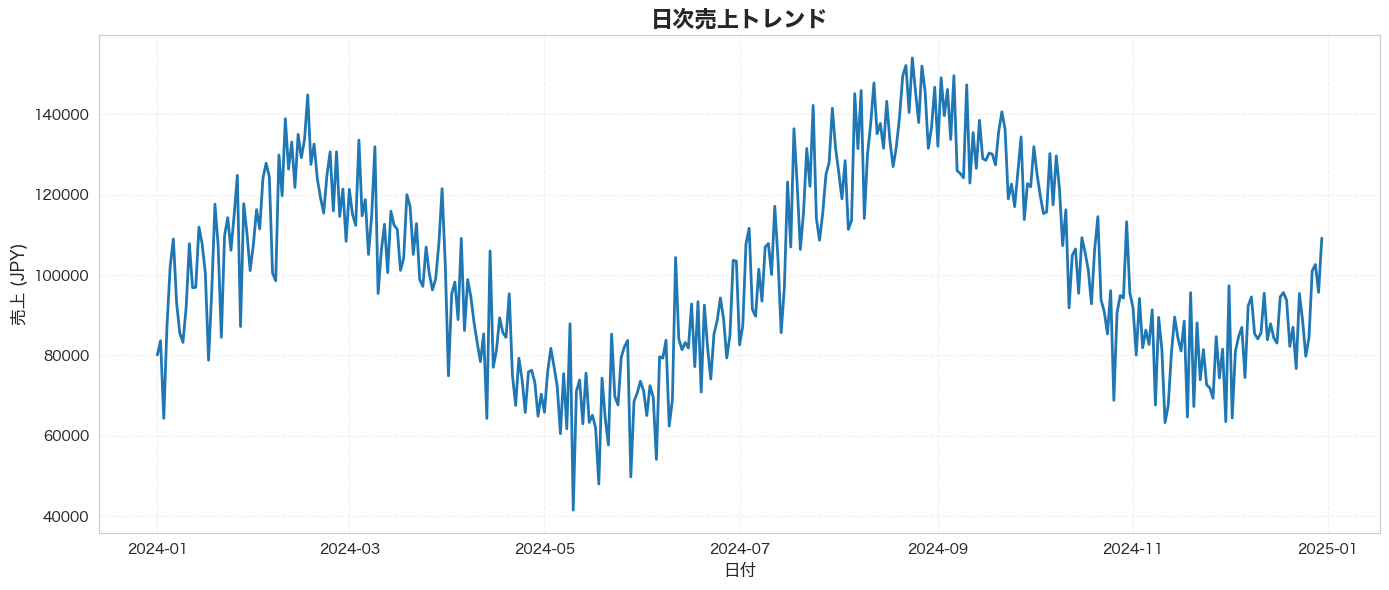

In [ ]:
import matplotlib.pyplot as plt  # 基本的な可視化
from matplotlib import rcParams

# 日本語フォントの設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']


# 日次売上を集計
daily_sales = sales_data.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales.values, color='#1f77b4', linewidth=2)
plt.title('日次売上トレンド', fontsize=16, fontweight='bold')
plt.xlabel('日付', fontsize=12)
plt.ylabel('売上 (JPY)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Seaborn - 統計的可視化

[doc](https://seaborn.pydata.org/api.html)

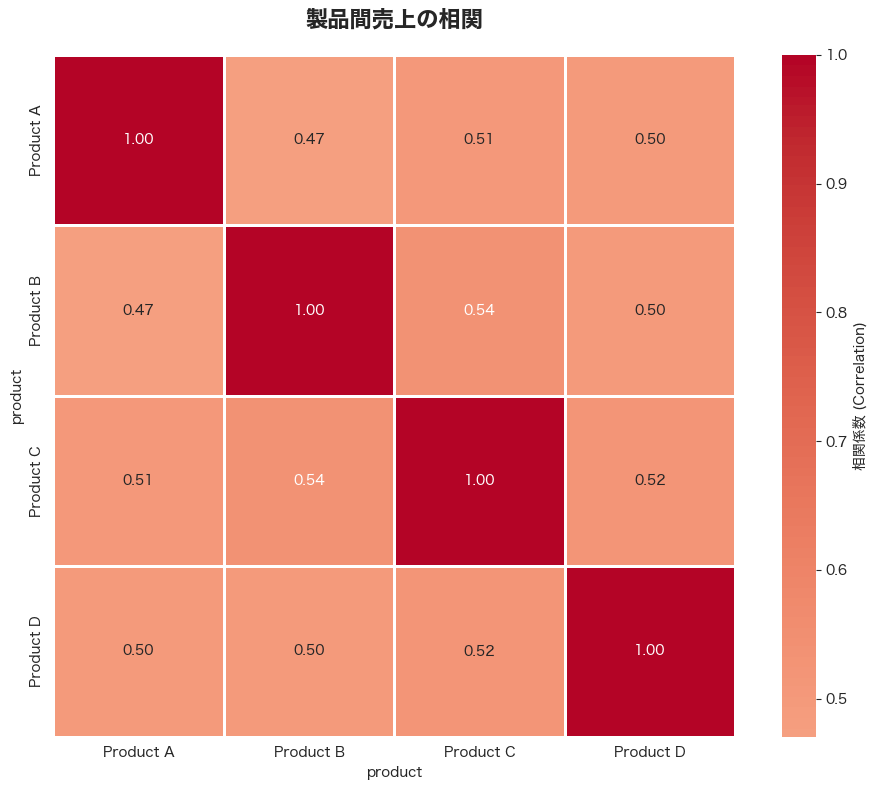

In [ ]:
import seaborn as sns       # 統計的可視化

# 各製品の日次売上を集計してピボット
product_daily_sales = sales_data.groupby(['date', 'product'])['sales'].sum().unstack(fill_value=0)

# 相関行列を計算
correlation_matrix = product_daily_sales.corr()

# 相関ヒートマップを作成
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'label': '相関係数 (Correlation)'})
plt.title('製品間売上の相関', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 相関の計算 
<details>
<summary>Click to expand</summary>


d: date

p: product

r: region

R: region総数

T: trend

S: seasonality

X: sales

$$
\begin{align}

\text{corr}(X_{p=A}, X_{p=B}) &= \frac{\text{COV}(X_{p=A}, X_{p=B})}{\sigma_{X_{p=A}}\sigma_{X_{p=B}}} \\
 &= \frac{\text{COV}(X_{p=A}, X_{p=B})}{\sigma_{X_{p}}^2} 

\end{align}\\[2em]

\begin{align}

X_{p} &= \sum_{r=1}^{R} (\text{U}_{d,p,r} + \text{T}_d + \text{S}_d) \\
&= \sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d 
\end{align} \\[2em]


\begin{align}

\text{COV}(X_{p=A}, X_{p=B}) &= \text{COV}(\sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d, \sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d) \\[2em]
&=  \text{VAR}(R\text{T}_d) + \text{VAR}(R\text{S}_d) + \text{COV}(R\text{T}_d, R\text{S}_d) \\
&=  R^2 (\text{VAR}(\text{T}_d) + \text{VAR}(\text{S}_d) + \text{COV}(\text{T}_d, \text{S}_d))

\end{align}\\[2em]


\text{VAR}(\text{T}_d) = \frac{5^2 (364)^2}{12} \approx 276033 \\[2em]
\text{VAR}(\text{S}_d) = 2000^2 \text{VAR}(sin(i/30)) \approx 2000^2 (1/2) \approx 2000000 \\[2em]

\begin{align}

\text{COV}(\text{T}_d, \text{S}_d) &=  E[TS] - E[T] \cdot E[S] \\ 
&\approx E[TS] \hspace{2em} (E[S] \approx 0)\\
&= \frac{1}{365}\sum_{d=0}^{364} (5d)(2000\sin(d/30)) \\
&= \frac{10,000}{365}\sum_{d=0}^{364} d\sin(d/30) \\
&\approx -283977
\end{align}
\\[2em]
\begin{align}
\text{COV}(X_{p=A}, X_{p=B}) &= R^2 (276033 + 2000000 -283977) \\ 
&= R^2 \times 1992056 \\
\end{align}\\[2em]
\begin{align} 

\sigma_{X} &= R^2 (276033 + 2000000 -283977) + \text{VAR}(\sum_{r=1}^{R} U) \\
&= R^2 \times 1992056 + R \frac{(10000-1000) ^ 2}{12} 
\end{align}
$$

R = 4 の時:
$$
\begin{align}

\text{corr}(X_{p=A}, X_{p=B}) &= \frac{4^2 \times 1992056}{4^2 \times 1992056 + 4 \frac{9000^2}{12}} \\
&=0.54

\end{align}\\[2em]

$$

## Q. なんで理論上の計算値と実際取った数字が違いますか？
<details>
<summary>Hint</summary>
E[S]を実際計算してみましよう。
</details>

</details>

### 組み合わせ例


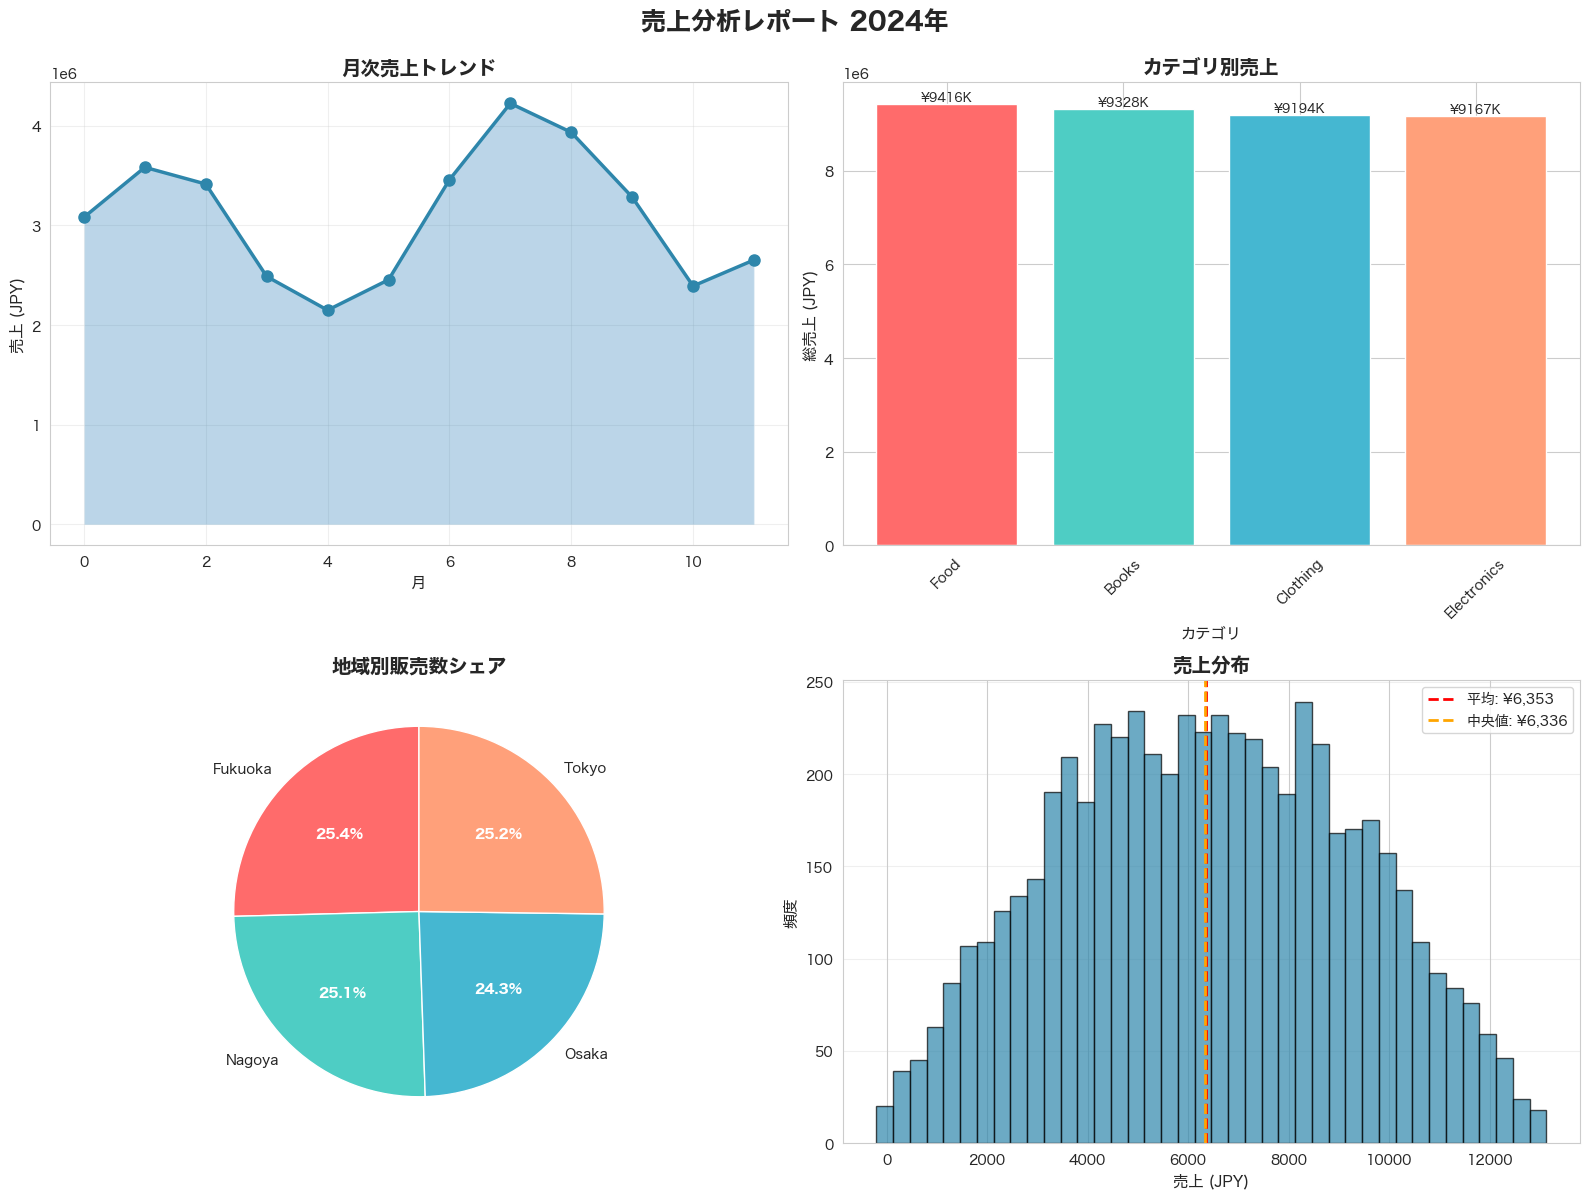

In [ ]:
# スタイル設定
sns.set_style("whitegrid")

# 日本語フォントの設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']

# 4つのサブプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('売上分析レポート 2024年', 
             fontsize=18, fontweight='bold', y=0.995)

# 1. 月次売上トレンド
sales_data['month'] = sales_data['date'].dt.to_period('M')
monthly_sales = sales_data.groupby('month')['sales'].sum()
axes[0, 0].plot(range(len(monthly_sales)), monthly_sales.values, 
                marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
axes[0, 0].set_title('月次売上トレンド', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('月', fontsize=11)
axes[0, 0].set_ylabel('売上 (JPY)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(range(len(monthly_sales)), monthly_sales.values, alpha=0.3)

# 2. カテゴリ別売上
category_sales = sales_data.groupby('category')['sales'].sum().sort_values(ascending=False)
bars = axes[0, 1].bar(category_sales.index, category_sales.values, 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0, 1].set_title('カテゴリ別売上', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('カテゴリ', fontsize=11)
axes[0, 1].set_ylabel('総売上 (JPY)', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'¥{height/1000:.0f}K', ha='center', va='bottom', fontsize=9)

# 3. 地域別販売数シェア
region_units = sales_data.groupby('region')['units'].sum()
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
wedges, texts, autotexts = axes[1, 0].pie(region_units.values, 
                                           labels=region_units.index,
                                           autopct='%1.1f%%',
                                           colors=colors_pie,
                                           startangle=90)
axes[1, 0].set_title('地域別販売数シェア', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. 売上分布
axes[1, 1].hist(sales_data['sales'], bins=40, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('売上分布', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('売上 (JPY)', fontsize=11)
axes[1, 1].set_ylabel('頻度', fontsize=11)
axes[1, 1].axvline(sales_data['sales'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'平均: ¥{sales_data["sales"].mean():,.0f}')
axes[1, 1].axvline(sales_data['sales'].median(), color='orange', linestyle='--', linewidth=2,
                   label=f'中央値: ¥{sales_data["sales"].median():,.0f}')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

------------
## 機械学習の基礎

機械学習とは、コンピューターが大量のデータからパターンやルールを自動で学習し、その学習結果をもとに予測や分類、意思決定などを行う技術です。

### 機械学習の3つのタイプ

- 教師あり学習（Supervised Learning）
  - **定義**: ラベル付きデータから学習し、新しいデータを予測

  - 分類（Classification）
    - **目的**: データをカテゴリに分類
    - **例**:
      - 画像認識（猫/犬/鳥）
      - 病気診断（陽性/陰性）

  - 回帰（Regression）
    - **目的**: 連続値を予測
    - **例**:
      - 株価予測
      - 売上予測

- 教師なし学習（Unsupervised Learning）
  - **定義**: ラベルなしデータから隠れたパターンや構造を発見

  - クラスタリング
    - **目的**: 類似したデータをグループ化
    - **例**:
      - 文書のトピック分類
      - 異常検知

- 強化学習（Reinforcement Learning）

  - **定義**: 試行錯誤を通じて最適な行動を学習

  - **概念**: エージェントが環境と相互作用し、報酬を最大化
  - **例**:
    - ゲームAI（囲碁、チェス）
    - 自動運転




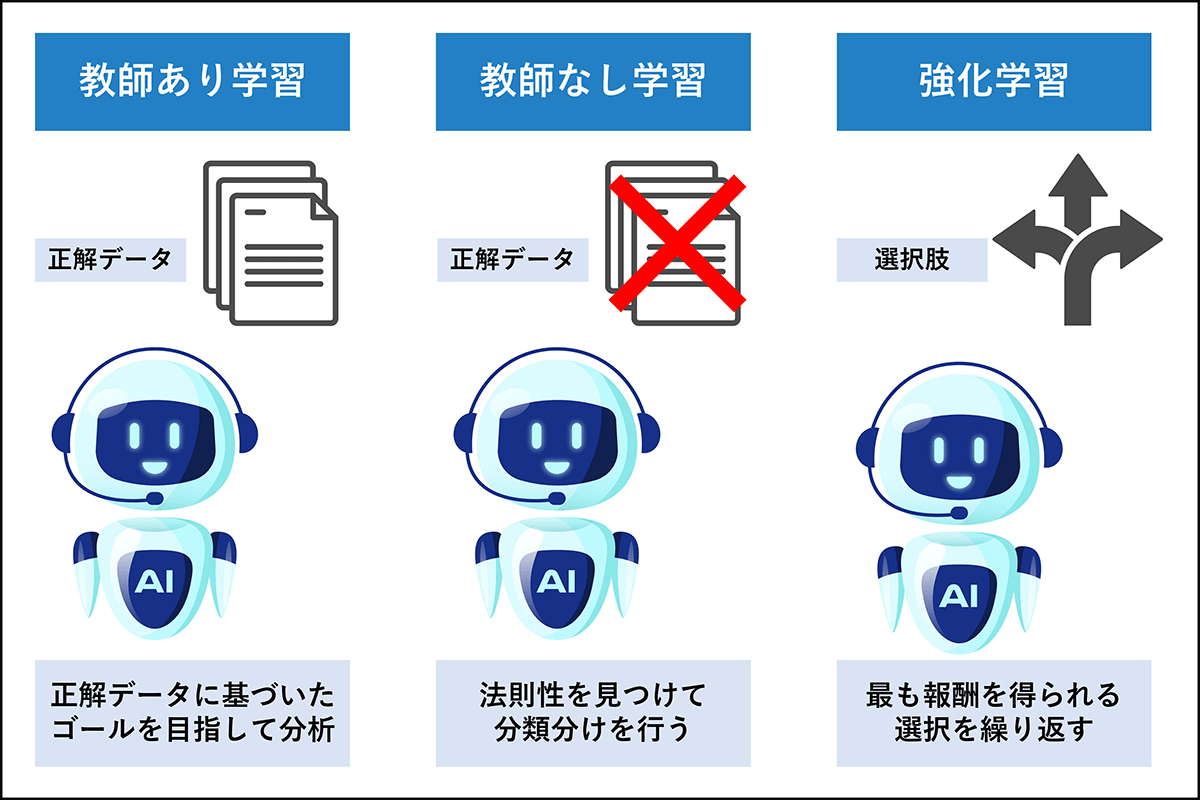

----------
## データ前処理

### 1. 正規化 (Normalization)

正規化は、データの値を特定の範囲（通常は0から1の間）にスケーリングする手法です。データの相対的な関係を保ちながら、すべての値を同じスケールに変換します。

**Min-Max正規化:**

$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$

ここで：
- $x$ = 元の値
- $x_{min}$ = データセット内の最小値
- $x_{max}$ = データセット内の最大値
- $x'$ = 正規化後の値（0から1の範囲）

この式により、すべての値が0から1の範囲に変換されます。

**なぜやる:**

- 勾配降下法の収束が早まる
- アルゴリズムの学習が安定する

### 2. 標準化 (Standardization)

標準化は、データの平均を0、標準偏差を1にする変換です。データを「平均からの標準偏差単位」で表現します。これをZ-score（Zスコア）とも呼びます。

**Z-score標準化:**

$$z = \frac{x - \mu}{\sigma}$$

ここで：
- $x$ = 元の値
- $\mu$ = データセットの平均値
- $\sigma$ = データセットの標準偏差
- $z$ = 標準化後の値（Z-score）


この式により、データの中心が0になり、散らばり具合が標準化されます。

**なぜやる:**

- アルゴリズムの学習が安定する
- 異常値の識別が容易

## エンコーディング

### 1. ワンホットエンコーディング (One-Hot Encoding)

ワンホットエンコーディングは、カテゴリカル変数を複数の二値変数（0または1）に変換する手法です。各カテゴリに対して1つの列を作成し、該当するカテゴリの列のみ1、他は0とします。

**変換例:**

元のデータ：
```
色: [赤, 青, 緑, 赤]
```

変換後：
```
色_赤: [1, 0, 0, 1]
色_青: [0, 1, 0, 0]
色_緑: [0, 0, 1, 0]
```

**表現:**

各サンプル $i$ について、カテゴリ $k$ の場合：

$$x_j^{(i)} = \begin{cases} 1 & \text{if } j = k \\ 0 & \text{otherwise} \end{cases}$$

ここで：
- $x_j^{(i)}$ = サンプル $i$ のカテゴリ $j$ の値
- $k$ = 実際のカテゴリ
- 各サンプルで $\sum_{j=1}^{n} x_j^{(i)} = 1$ （1つだけが1）



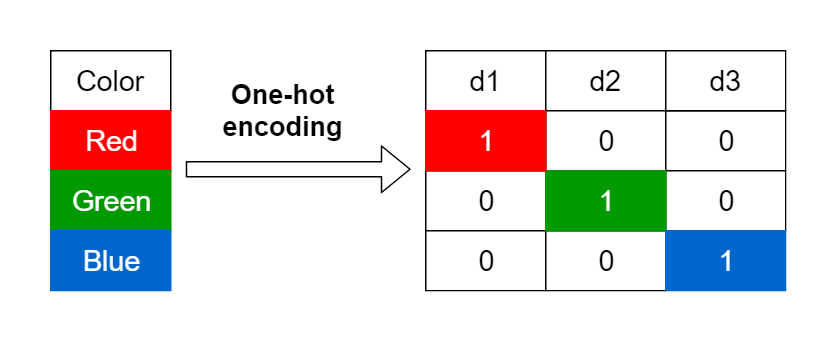

### データ型の変換
データ型の変換は、カラムを適切な型（数値、文字列、日付など）に変更する処理です。多くの場合、データ読み込み時に型が誤って推定されるため、正しい型に変換することで分析や計算が可能になります。

### 前処理例

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

X = sales_data.copy()

# ワンホットエンコーディング実行
X_encoded = pd.get_dummies(X, columns=['product', 'category', 'region'], prefix=['prod', 'cat', 'reg']).astype(int)

# 日付列を数値に変換
if 'date' in X.columns:
    X['date'] = X['date'].astype('int64') / 10**9  # Unixタイムスタンプ（秒）

# 数値列のみを選択
numeric_columns = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
X_numeric = X[numeric_columns].copy()

# =====================================
# 正規化例（Min-Max Normalization）
# =====================================

# salesとunitsを正規化
scaler_minmax = MinMaxScaler()
columns_to_normalize = ['date', 'sales', 'units']

X_normalized = X_numeric.copy()
X_normalized[columns_to_normalize] = scaler_minmax.fit_transform(X_numeric[columns_to_normalize])
y = X_normalized['sales']

X = pd.concat([X_encoded.drop(columns=['date', 'month', 'sales', 'units']), X_normalized[['date', 'sales', 'units']]], axis=1)

X.head(5)

,prod_Product A,prod_Product B,prod_Product C,prod_Product D,cat_Books,cat_Clothing,cat_Electronics,cat_Food,reg_Fukuoka,reg_Nagoya,reg_Osaka,reg_Tokyo,date,sales,units
0,1,0,0,0,0,0,1,0,0,0,0,1,0.0,0.524181,0.067416
1,1,0,0,0,0,0,1,0,0,0,1,0,0.0,0.339508,0.022472
2,1,0,0,0,0,0,1,0,0,1,0,0,0.0,0.110954,0.550562
3,1,0,0,0,0,0,1,0,1,0,0,0,0.0,0.369512,1.000000
4,0,1,0,0,0,1,0,0,0,0,0,1,0.0,0.735932,0.842697


### データの分割 (Train-Test Split)

トレーニングデータとテストデータの分割は、モデルの性能を正しく評価するために、データを2つのセットに分ける手法です。通常、データの70-90%を学習用、残りの10-30%をテスト用に分割します。

#### 分割の基本概念

**トレーニングデータ (Training Data)**
- モデルの学習に使用するデータ
- モデルはこのデータからパターンを学習する
- 通常、全体の70-90%を使用

**テストデータ (Test Data)**
- モデルの性能評価に使用するデータ
- モデルが**見たことがない**データ
- 通常、全体の10-30%を使用

#### なぜやる

**オーバーフィットの検出**
- トレーニングデータだけで評価すると、モデルがトレーニングデータを「暗記」(memorization)している可能性がある
- テストデータで評価することで、真の汎化性能がわかる
- トレーニング精度は高いがテスト精度が低い → オーバーフィットのサイン

**汎化性能の評価**
- モデルが新しいデータに対してどれだけ正確に予測できるか
- 実世界での性能を推定できる
- 学習の時に見ていないデータでの性能が重要


#### 時系列データの分割例

時系列データでは、**時間順を保つことが重要**です：

```
全データ: [1月, 2月, 3月, 4月, 5月, 6月, 7月, 8月, 9月, 10月]

トレーニングデータ: [1月, 2月, 3月, 4月, 5月, 6月, 7月, 8月, 9月]
テストデータ: [10月]

理由: 過去のデータで学習し、未来のデータで予測する
```

In [ ]:
split_idx = int(len(X) * 0.9)

X_train = X[:split_idx].drop(columns=['sales'])
X_test = X[split_idx:].drop(columns=['sales'])
y_train = y[:split_idx]
y_test = y[split_idx:]


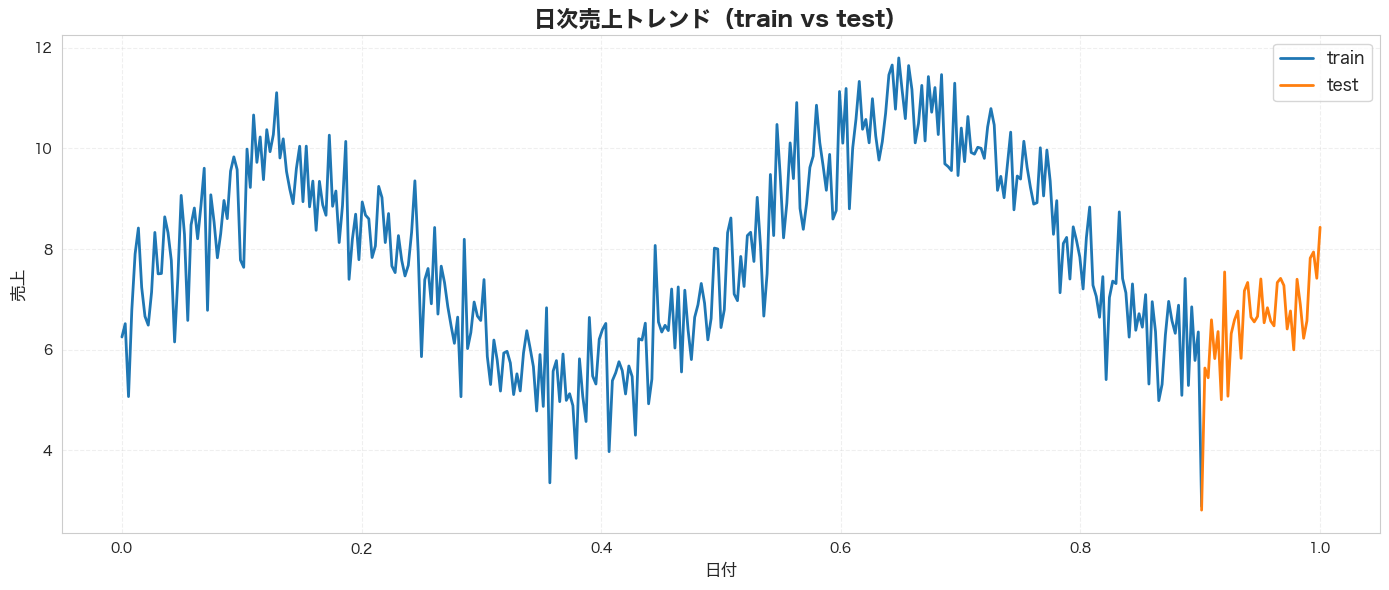

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_data = pd.DataFrame({
    'date': X_train['date'].values,
    'sales': y_train.values
})

test_data = pd.DataFrame({
    'date': X_test['date'].values,
    'sales': y_test.values
})

daily_sales_train = train_data.groupby('date')['sales'].sum()
daily_sales_test = test_data.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales_train.index, daily_sales_train.values, color='#1f77b4', linewidth=2, label='train')
plt.plot(daily_sales_test.index, daily_sales_test.values, color='#ff7f0e', linewidth=2, label='test')
plt.title('日次売上トレンド（train vs test）', fontsize=16, fontweight='bold')
plt.xlabel('日付', fontsize=12)
plt.ylabel('売上', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

----------
## モデル種類・紹介

In [ ]:
# util: モデル予測プロット

def plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train, y_pred_test):
    # 訓練データの集約
    train_results = pd.DataFrame({
        'date': X_train_split['date'],
        'actual': y_train_split.values,
        'predicted': y_pred_train
    })
    
    # テストデータの集約
    test_results = pd.DataFrame({
        'date': X_test_split['date'],
        'actual': y_test_split.values,
        'predicted': y_pred_test
    })

    # 日付ごとに合計
    daily_train = train_results.groupby('date').agg({
        'actual': 'sum',
        'predicted': 'sum'
    }).reset_index()
    
    daily_test = test_results.groupby('date').agg({
        'actual': 'sum',
        'predicted': 'sum'
    }).reset_index()

    # プロット（時系列）
    plt.figure(figsize=(14, 6))
    plt.plot(daily_train['date'], daily_train['actual'], alpha=0.5, label='実績（train）', linewidth=2, color='#1f77b4')
    plt.plot(daily_train['date'], daily_train['predicted'], alpha=0.5, label='予測値（train）', linewidth=2, color='#aec7e8')
    plt.plot(daily_test['date'], daily_test['actual'], alpha=0.7, label='実績（test）', linewidth=2, color='#ff7f0e')
    plt.plot(daily_test['date'], daily_test['predicted'], alpha=0.7, label='予測値（test）', linewidth=2, color='#ffbb78')
    plt.xlabel('日付')
    plt.ylabel('売上')
    plt.title('実績 vs 予測値（日次集計）')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_results.png', dpi=150, bbox_inches='tight')
    plt.show()

### 1. 線形モデル Linear Models

MSE: 0.04
R²スコア: -0.2035


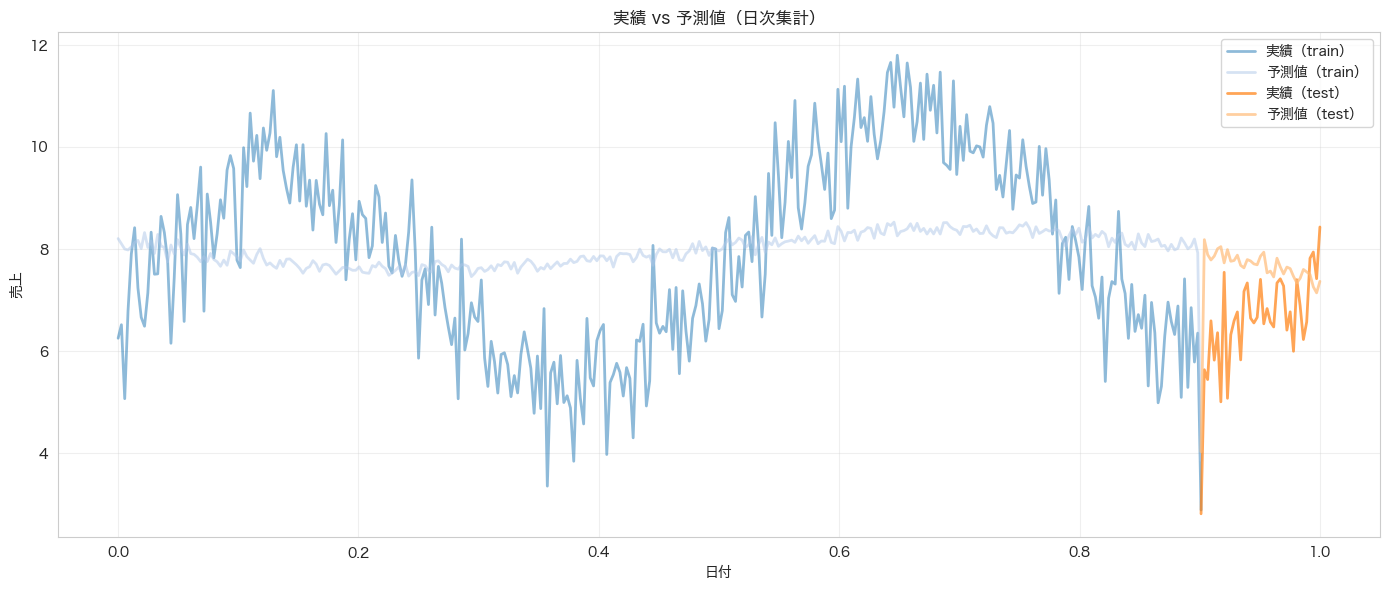

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


# =====================================
# 1. 線形モデル: SVM (Support Vector Machine)
# =====================================

from sklearn.svm import SVR

# モデル作成と訓練
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_svm = svm_model.predict(X_train_split)
y_pred_svm = svm_model.predict(X_test_split)

# 評価
mse_svm = mean_squared_error(y_test_split, y_pred_svm)
r2_svm = r2_score(y_test_split, y_pred_svm)

print(f"MSE: {mse_svm:.2f}")
print(f"R²スコア: {r2_svm:.4f}")

plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_svm, y_pred_svm)

### 2. ツリーモデル Tree Models

MSE: 0.04
R²スコア: -0.2066


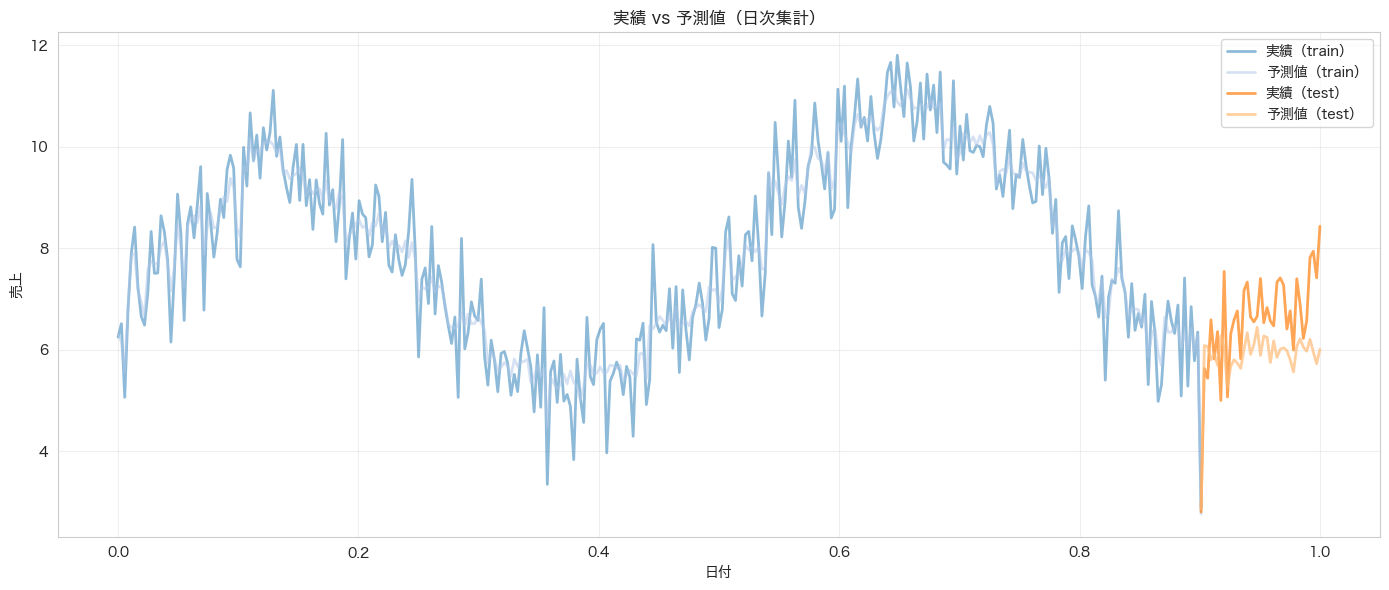

In [ ]:

# =====================================
# 2. ツリーモデル: XGBoost
# =====================================

from xgboost import XGBRegressor

# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# モデル作成と訓練
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_xgb = xgb_model.predict(X_train_split)
y_pred_xgb = xgb_model.predict(X_test_split)

# 評価
mse_xgb = mean_squared_error(y_test_split, y_pred_xgb)
r2_xgb = r2_score(y_test_split, y_pred_xgb)

print(f"MSE: {mse_xgb:.2f}")
print(f"R²スコア: {r2_xgb:.4f}")

plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_xgb, y_pred_xgb)

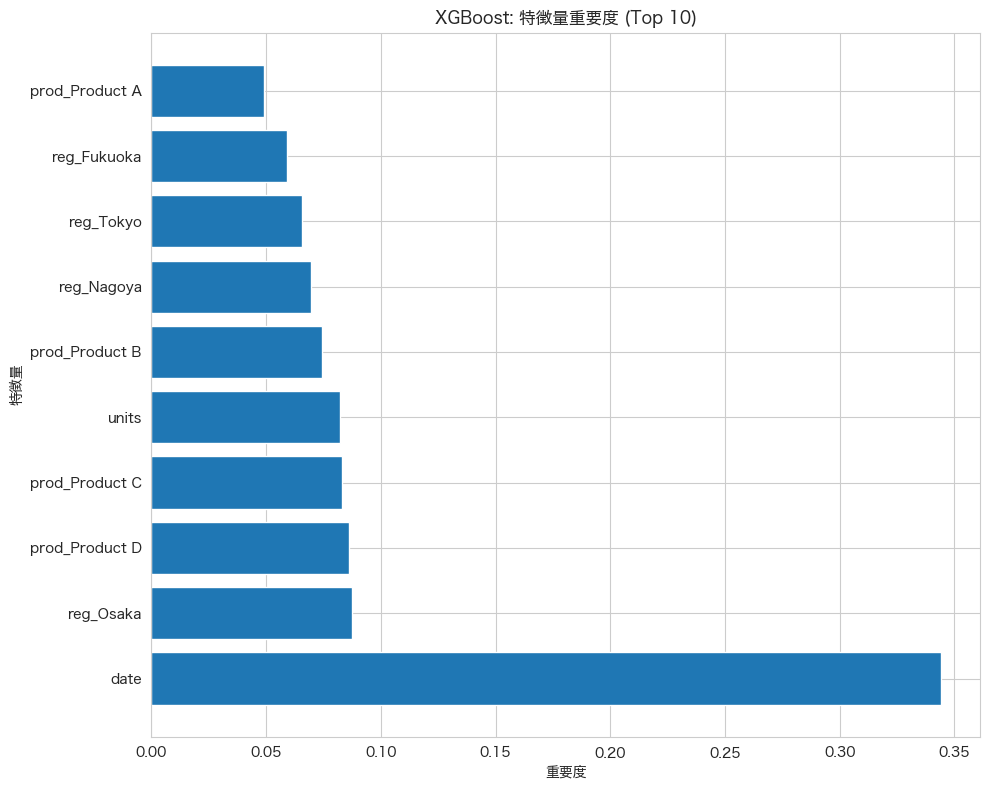

In [ ]:
# 特徴量重要度のプロット
plt.figure(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('重要度')
plt.ylabel('特徴量')
plt.title('XGBoost: 特徴量重要度 (Top 10)')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


### 3. Simple NN

MSE: 0.07
R²スコア: -0.7705
反復回数: 126


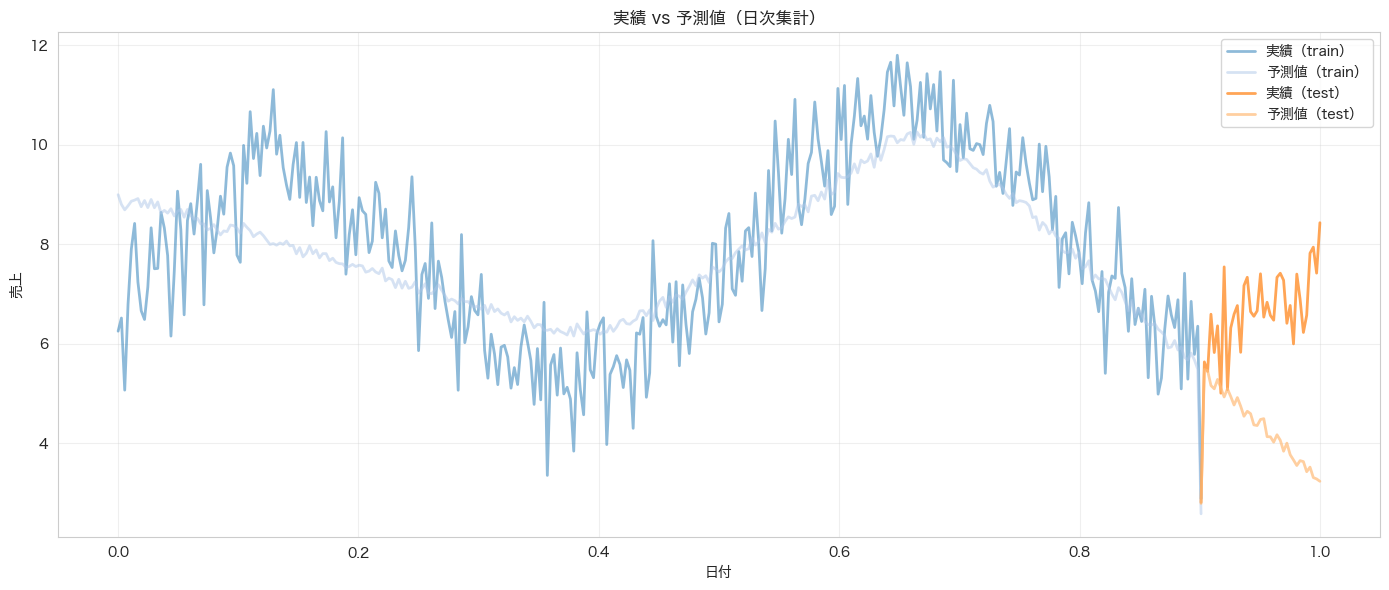

In [ ]:

# =====================================
# 3. ニューラルネットワーク: Simple NN
# =====================================

from sklearn.neural_network import MLPRegressor

# モデル作成と訓練
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True
)
nn_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_nn = nn_model.predict(X_train_split)
y_pred_nn = nn_model.predict(X_test_split)

# 評価
mse_nn = mean_squared_error(y_test_split, y_pred_nn)
r2_nn = r2_score(y_test_split, y_pred_nn)

print(f"MSE: {mse_nn:.2f}")
print(f"R²スコア: {r2_nn:.4f}")
print(f"反復回数: {nn_model.n_iter_}")

# プロット
plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_nn, y_pred_nn)

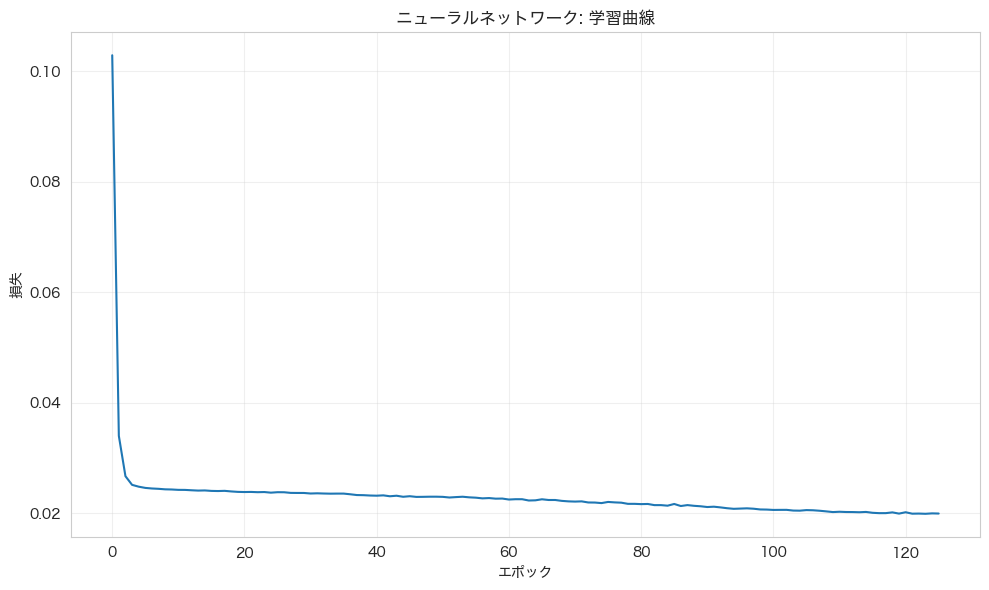

In [ ]:

# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_)
plt.xlabel('エポック')
plt.ylabel('損失')
plt.title('ニューラルネットワーク: 学習曲線')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('nn_learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()


### 4. ディープラーニング: LSTM

In [ ]:

# =====================================
# 4. ディープラーニング: LSTM/RNN
# =====================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTMのためのデータ整形（時系列として扱う）
# 各日付の全製品・地域のデータをまとめて時系列に
def create_sequences(data, target, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps])
        y_seq.append(target[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_lstm, y_lstm = create_sequences(X_train.values, y_train.values, time_steps)

# 訓練・テスト分割
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"LSTMトレーニングデータ: {X_train_lstm.shape}")
print(f"LSTMテストデータ: {X_test_lstm.shape}")

# モデル作成
lstm_model = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(time_steps, X_train.shape[1]), return_sequences=True),
    layers.LSTM(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nモデル構造:")
lstm_model.summary()

# トレーニング
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# 予測
y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

# 評価
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"\nMSE: {mse_lstm:.2f}")
print(f"R²スコア: {r2_lstm:.4f}")


ModuleNotFoundError: No module named 'distutils'

In [ ]:

# プロット: 予測結果
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm[:200], label='実際の値', alpha=0.7)
plt.plot(y_pred_lstm[:200], label='予測値', alpha=0.7)
plt.xlabel('時間ステップ')
plt.ylabel('売上')
plt.title('LSTM: 実際の値 vs 予測値 (最初の200ステップ)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_results.png', dpi=150, bbox_inches='tight')
plt.show()

# プロット: 学習履歴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], label='訓練損失')
ax1.plot(history.history['val_loss'], label='検証損失')
ax1.set_xlabel('エポック')
ax1.set_ylabel('損失 (MSE)')
ax1.set_title('LSTM: 学習曲線')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['mae'], label='訓練MAE')
ax2.plot(history.history['val_mae'], label='検証MAE')
ax2.set_xlabel('エポック')
ax2.set_ylabel('MAE')
ax2.set_title('LSTM: MAE曲線')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:

# =====================================
# 5. 時系列モデル: ARIMA
# =====================================
print("\n" + "="*60)
print("5. ARIMA (AutoRegressive Integrated Moving Average)")
print("="*60)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMAのためのデータ準備（1つの時系列として集約）
# 日付ごとの合計売上を計算
sales_ts = sales_data.groupby('date')['sales'].sum().reset_index()
sales_ts.set_index('date', inplace=True)

print(f"時系列データ: {len(sales_ts)} 日分")

# 訓練・テスト分割
train_size = int(len(sales_ts) * 0.8)
train_ts = sales_ts[:train_size]
test_ts = sales_ts[train_size:]

print(f"訓練期間: {len(train_ts)} 日")
print(f"テスト期間: {len(test_ts)} 日")

# ARIMAモデル作成と訓練
# (p, d, q) = (5, 1, 2) - これは例です。実際は最適なパラメータを探索
arima_model = ARIMA(train_ts, order=(5, 1, 2))
arima_fitted = arima_model.fit()

print("\nARIMAモデルサマリー:")
print(arima_fitted.summary())

# 予測
forecast = arima_fitted.forecast(steps=len(test_ts))

# 評価
mse_arima = mean_squared_error(test_ts, forecast)
r2_arima = r2_score(test_ts, forecast)

print(f"\nMSE: {mse_arima:.2f}")
print(f"R²スコア: {r2_arima:.4f}")

# プロット: 予測結果
plt.figure(figsize=(14, 6))
plt.plot(train_ts.index, train_ts.values, label='訓練データ', color='blue')
plt.plot(test_ts.index, test_ts.values, label='実際の値', color='green')
plt.plot(test_ts.index, forecast, label='予測値', color='red', linestyle='--')
plt.xlabel('日付')
plt.ylabel('売上合計')
plt.title('ARIMA: 時系列予測')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('arima_results.png', dpi=150, bbox_inches='tight')
plt.show()

# プロット: ACF と PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(train_ts, lags=30, ax=ax1)
ax1.set_title('自己相関関数 (ACF)')

plot_pacf(train_ts, lags=30, ax=ax2)
ax2.set_title('偏自己相関関数 (PACF)')

plt.tight_layout()
plt.savefig('arima_acf_pacf.png', dpi=150, bbox_inches='tight')
plt.show()

# =====================================
# 全モデルの比較
# =====================================
print("\n" + "="*60)
print("全モデルの性能比較")
print("="*60)

results_df = pd.DataFrame({
    'モデル': ['SVM', 'XGBoost', 'NN', 'LSTM', 'ARIMA'],
    'MSE': [mse_svm, mse_xgb, mse_nn, mse_lstm, mse_arima],
    'R²スコア': [r2_svm, r2_xgb, r2_nn, r2_lstm, r2_arima]
})

print(results_df.to_string(index=False))

# プロット: モデル比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(results_df['モデル'], results_df['MSE'], color=['blue', 'green', 'orange', 'red', 'purple'])
ax1.set_ylabel('MSE')
ax1.set_title('モデル比較: MSE（低いほど良い）')
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(results_df['モデル'], results_df['R²スコア'], color=['blue', 'green', 'orange', 'red', 'purple'])
ax2.set_ylabel('R²スコア')
ax2.set_title('モデル比較: R²スコア（高いほど良い）')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n全モデルの訓練と評価が完了しました！")

---
## 誤差メトリクス


---
## 特徴量